In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [5]:
X,y = fetch_openml("breast-w", version=1, as_frame=True, return_X_y=True)
data = pd.concat([X,y], axis=1)
#data['target'] = np.where(data['class'] == 'good', 1,0)
#data = data.drop('target', axis=1)
data.head()

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,benign
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,benign
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,benign
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,benign
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,benign


In [13]:
data.dtypes

preg      float64
plas      float64
pres      float64
skin      float64
insu      float64
mass      float64
pedi      float64
age       float64
target      int64
dtype: object

<AxesSubplot:>

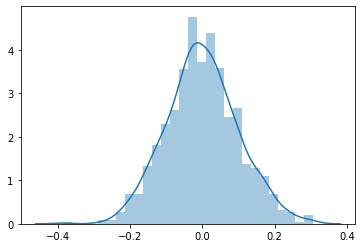

In [22]:
import seaborn as sns
from numpy import random

#x = random.normal(loc=1, scale=2, size=(10,10))
mu, sigma = 0, 0.1
x = np.random.normal(mu, sigma, 1000)
sns.distplot(x, norm_hist=True)

<AxesSubplot:xlabel='Clump_Thickness'>

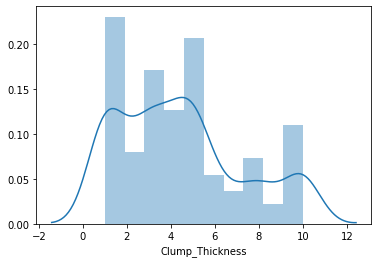

In [15]:
import seaborn as sns
sns.distplot(data["Clump_Thickness"], norm_hist=True)

In [255]:
# Change category dtypes to object so that Tensorflow will recognise the type
categorical_features = data.select_dtypes(include=['category']).columns

for col in categorical_features:
    data[col] = data[col].astype('object')

data.dtypes

checking_status            object
duration                  float64
credit_history             object
purpose                    object
credit_amount             float64
savings_status             object
employment                 object
installment_commitment    float64
personal_status            object
other_parties              object
residence_since           float64
property_magnitude         object
age                       float64
other_payment_plans        object
housing                    object
existing_credits          float64
job                        object
num_dependents            float64
own_telephone              object
foreign_worker             object
target                      int64
dtype: object

In [256]:
numeric_features = train.select_dtypes(include=['int64', 'float64']).drop('target', axis=1).columns
categorical_features = train.select_dtypes(include=['object']).columns

In [257]:
data[categorical_features].nunique()

checking_status         4
credit_history          5
purpose                10
savings_status          5
employment              5
personal_status         4
other_parties           3
property_magnitude      4
other_payment_plans     3
housing                 3
job                     4
own_telephone           2
foreign_worker          2
dtype: int64

In [258]:
data.dtypes

checking_status            object
duration                  float64
credit_history             object
purpose                    object
credit_amount             float64
savings_status             object
employment                 object
installment_commitment    float64
personal_status            object
other_parties              object
residence_since           float64
property_magnitude         object
age                       float64
other_payment_plans        object
housing                    object
existing_credits          float64
job                        object
num_dependents            float64
own_telephone              object
foreign_worker             object
target                      int64
dtype: object

In [259]:
data['personal_status'].value_counts()

male single           548
female div/dep/mar    310
male mar/wid           92
male div/sep           50
Name: personal_status, dtype: int64

In [260]:
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]
msk_train = np.random.rand(len(train)) < 0.8
validation = train[~msk_train]

print("Train data size:", len(train))
print("Test data size:", len(test))
print("Validation data size:", len(validation))


Train data size: 803
Test data size: 197
Validation data size: 154


In [261]:
test.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'target'],
      dtype='object')

In [262]:
validation.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'target'],
      dtype='object')

In [263]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [264]:
batch_size = 32 
train_ds = df_to_dataset(train, batch_size=batch_size)
validation_ds = df_to_dataset(validation, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [265]:
train['job'].unique()

array(['skilled', 'unskilled resident', 'high qualif/self emp/mgmt',
       'unemp/unskilled non res'], dtype=object)

In [266]:
numeric_features

Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_dependents'],
      dtype='object')

In [267]:
feature_columns = []

In [268]:
# Creating one hot encoded feature columns

#cat_cols_list = []

for column in categorical_features:
    column = feature_column.categorical_column_with_vocabulary_list(
        column, data[column].unique().tolist())
    column = feature_column.indicator_column(column)
    feature_columns.append(column)


In [269]:
# Creating age buckets
age = feature_column.numeric_column("age")
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

In [270]:
# Remaining numeric features
remaining_numeric = train.select_dtypes(include=['int64', 'float64']).drop(['age', 'target'], axis=1).columns.tolist()

#remaining_numeric_cols = []

for column in remaining_numeric:
    column = feature_column.numeric_column(column)
    feature_columns.append(column)

In [271]:
# feature layer

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [280]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=validation_ds,
          epochs=5)

Epoch 1/5
26/26 [==============================] - 0s 16ms/step - loss: 65.0666 - accuracy: 0.5479 - val_loss: 6.3727 - val_accuracy: 0.7403
Epoch 2/5
26/26 [==============================] - 0s 2ms/step - loss: 5.3843 - accuracy: 0.5579 - val_loss: 0.7484 - val_accuracy: 0.7403
Epoch 3/5
26/26 [==============================] - 0s 2ms/step - loss: 5.0246 - accuracy: 0.5567 - val_loss: 0.7027 - val_accuracy: 0.7403
Epoch 4/5
26/26 [==============================] - 0s 2ms/step - loss: 7.5571 - accuracy: 0.5679 - val_loss: 9.3581 - val_accuracy: 0.7403
Epoch 5/5
26/26 [==============================] - 0s 3ms/step - loss: 14.8491 - accuracy: 0.6065 - val_loss: 5.3144 - val_accuracy: 0.7403
